### Creating the auxiliary input images

In [45]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 1. Load Rain Data
def load_rain_data(filepath):
    with rasterio.open(filepath) as src:
        rain = src.read(1)  # Load the first band
        transform = src.transform
    return rain, transform

# Dynamic path construction using os.path
data_path = os.path.join("..", "CNN_from_R", "images_for_CNN", "rainfall_raster_bound.tif")
rain, transform = load_rain_data(data_path)

# 2. Load the recharge data
clor = pd.read_csv("../Data/dat07_u.csv")
quant = "Recharge mean mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])


# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, rain, transform)

C:\Users\chari\AppData\Local\Temp\ipykernel_32904\2264289585.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv("../Data/dat07_u.csv")


In [46]:
## normalization

imgs_ann_min = np.min(imgs_ann)
imgs_ann_max = np.max(imgs_ann)
imgs_ann_normalized = (imgs_ann - imgs_ann_min) / (imgs_ann_max - imgs_ann_min)


In [47]:
with rasterio.open(data_path) as src:
    transform = src.transform
    pixel_width = transform[0]   # `a` value: pixel size in x-direction
    pixel_height = -transform[4] # `e` value (negated because it's typically negative)
    print(f"Pixel size: {pixel_width} x {pixel_height}")

Pixel size: 0.05 x 0.05


#### Checking the centered images

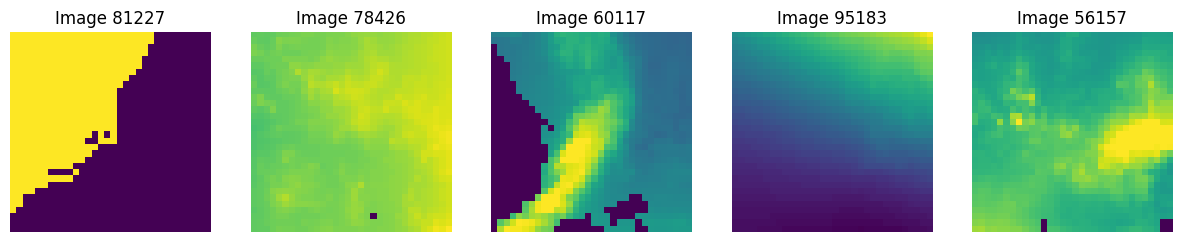

In [4]:
n = 5

# Select random images or specific indices
indices = np.random.choice(len(imgs_ann_normalized), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann_normalized[idx], cmap="viridis")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [5]:
recharge_data = clor[['lat','lon','Rain mm/y','Recharge mean mm/y']]
# Assuming loc is a pandas DataFrame containing the columns: "Bng_easting", "Bng_northing", "elevation"
loc = recharge_data[['lat','lon','Rain mm/y']]

# Calculate column means
recharge_data_mean = recharge_data.mean()

# Calculate column standard deviations
recharge_data_sd = recharge_data.std()


# Standardize the data (z-score normalization)
loc_ann = ((loc - loc_mean) / loc_sd).to_numpy()

In [6]:
recharge_data.shape[0]

98568

In [7]:
loc_ann[1]

array([ 0.54739326,  0.93351284, -0.13192523])

### Our network

In [8]:
# Use neural network to learn relationship between rain,location and recharge ####

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros

np.random.seed(321)
fold_size = recharge_data.shape[0] // 10
test = np.random.choice(recharge_data.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(recharge_data.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(recharge_data.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann_normalized[train], loc_ann[train]]
x_val = [imgs_ann_normalized[val], loc_ann[val]]
x_test = [imgs_ann_normalized[test], loc_ann[test]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], 32, 32, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], 32, 32, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], 32, 32, 1))


y_train = recharge_data['Recharge mean mm/y'].astype(float)[train]
y_val = recharge_data['Recharge mean mm/y'].astype(float)[val]
y_test = recharge_data['Recharge mean mm/y'].astype(float)[test]

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(32, 32, 1), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(10,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tf.random.normal(shape=tf.shape(x[:, 0:1]), mean=x[:, 0:1], stddev=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)


In [9]:
# Define the model
model = models.Model(inputs=[conv_input, auxiliary_input], outputs=main_output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='mean_squared_error',  # Adjust loss function as needed
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 128)  1280        conv_input[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 10, 10, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 10, 10, 128)  0           activation[0][0]                 
_______________________________________________________________________________________

In [60]:
contains_nan = np.isnan(imgs_ann).any()
print("Contains NaN:", contains_nan)

Contains NaN: False


In [55]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [10]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 10
epochs = 1

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.weights.h5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel.h5"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel.h5"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


Epoch 1/1000
7886/7886 - 426s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/1000
7886/7886 - 429s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/1000
7886/7886 - 289s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/1000
7886/7886 - 149s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/1000
7886/7886 - 152s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/1000
7886/7886 - 156s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/1000
7886/7886 - 165s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 8/1000
7886/7886 - 154s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 9/1000
7886/7886 - 142s - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 10/1000
7886/7886 - 14

KeyboardInterrupt: 

In [10]:
np.shape(x_test)

c:\Users\chari\miniconda3\envs\tf-gpu-cuda9\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


ValueError: could not broadcast input array from shape (9856,32,32,1) into shape (9856,)

In [14]:

# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject